### 1.) Import RL Book Code and Other Libraries

In [8]:
import sys
sys.path.insert(0, '/Users/johannesfuest/Documents/Master_Stanford/Winter_23/CME 241/RL-book/')
from typing import Callable, Sequence, Tuple, List
import numpy as np
import random
from scipy.stats import norm
import pandas as pd
from rl.function_approx import DNNApprox, LinearFunctionApprox, \
    FunctionApprox, DNNSpec, AdamGradient, Weights
from random import randrange
from numpy.polynomial.laguerre import lagval
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from random import randrange
import matplotlib.pyplot as plt
import numpy

### 2.) Create LSPI Algorithm

In [11]:
TrainingDataType = Tuple[float, float, float, float, float, float, 
                         float, float, float, float, float, float]

def fitted_lspi_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> LinearFunctionApprox:

    epsilon: float = 1e-3
    # Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
    #       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
    #       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
    #       'ScoreMarginxTimeRemainingInterval',
    #       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
    #       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    features = list(lambda x: x[i] for i in range(13))

    gamma: float = 1.0
    num_features: int = len(features) # will be hardcoded based on Spencer's code

    wts: np.ndarray = np.zeros(num_features)
    for _ in range(training_iters):
        a_inv: np.ndarray = np.eye(num_features) / epsilon
        b_vec: np.ndarray = np.zeros(num_features)
        cont: np.ndarray = np.dot(next_feature_vals, wts)
        cont_cond: np.ndarray = non_terminal * (cont > exer)
        for i in range(len(feature_vals)):
            phi1: np.ndarray = feature_vals[i]
            phi2: np.ndarray = phi1 - \
                cont_cond[i] * gamma * next_feature_vals[i]
            temp: np.ndarray = a_inv.T.dot(phi2)
            a_inv -= np.outer(a_inv.dot(phi1), temp) / (1 + phi1.dot(temp))
            b_vec += phi1 * (1 - cont_cond[i]) * exer[i] * gamma
        wts = a_inv.dot(b_vec)

    return LinearFunctionApprox.create(
        feature_functions=features,
        weights=Weights.create(wts)
    )

### 3.) Run LSPI Algorithm

In [84]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df_lspi = pd.read_csv('NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df_lspi = df_lspi.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df_lspi = df_lspi[df_lspi['RollingAvgPlayerPoints'] > 15]
names = df_lspi['Player']
opposition = df_lspi['Opponent']
date = df_lspi['Date']
# drop date, player, gameid
df_lspi = df_lspi[['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']]
# drop rows with missing values
df_lspi = df_lspi.dropna()
# convert to numpy array
feature_vals = df_lspi.to_numpy()
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=100,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted LSPI Model")

# Index(['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
#       'OpponentTeamRest', 'CumulativeTeamPointsInterval',
#       'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
#       'ScoreMarginxTimeRemainingInterval',
#       'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
#       'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']
res = np.matmul(feature_vals, flspi.weights.weights)
df_lspi['Player'] = names
df_lspi['res'] = res
df_lspi['Opposition'] = opposition
df_lspi['Date'] = date
# save output to csv
df_lspi.to_csv('lspi_output.csv')
print('done')

Fitted LSPI Model
done


### 4.) Create DQL Algorithm

In [13]:
class DQN_model(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.layer1 = nn.Linear(num_features, 15)
        self.layer2 = nn.Linear(15, 15)
        self.layer3 = nn.Linear(15, 1)

        # Initialize the linear layers
        nn.init.uniform_(self.layer1.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer2.weight, a = -0.1, b = 0.1)
        nn.init.uniform_(self.layer3.weight, a = -0.1, b = 0.1)
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        
    def forward(self, x):
        x2 = F.softplus(self.layer1(x))
        x3 = F.softplus(self.layer2(x2))
        return self.layer3(x3)
    
    def forward_in_batches(self, x):
        with torch.no_grad():
            batch_size = 100
            num_batches = int(np.ceil(x.shape[0] / batch_size))
            y = []
            for i in range(num_batches):
                y.append(self.forward(x[i * batch_size: min((i + 1) * batch_size, x.shape[0])]))
            return torch.cat(y)

def fitted_dql_put_option(
    feature_vals: np.ndarray,
    next_feature_vals: np.ndarray,
    training_iters: int,
    num_intervals: int
) -> torch.nn.Module:
    
    model = DQN_model(num_features=13)
    features_vals = torch.tensor(feature_vals, dtype=torch.float)
    next_feature_vals = torch.tensor(next_feature_vals, dtype=torch.float)

    exer: np.ndarray = np.array([max(row[1] - row[10] * (row[0] / num_intervals), 0) for row in feature_vals])
    non_terminal: np.ndarray = np.array([row[0] < num_intervals for row in feature_vals])

    alpha = 0.003

    for _ in tqdm(range(training_iters), desc="Epochs"):
        i = randrange(len(feature_vals))
        q_score = model(features_vals[i])
        q_score_next = model(next_feature_vals[i])
        grad = torch.autograd.grad(q_score, model.parameters())
        with torch.no_grad():
            if non_terminal[i]:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (max(exer[i], q_score_next)-q_score) * g)
            else:
                for param, g in zip(model.parameters(), grad):
                    param.add_(alpha * (exer[i]-q_score) * g)
                    
        alpha = max(alpha * 0.999, .00001) # decay learning rate
        model.zero_grad()  # reset gradients
    
    return model

### 5.) Run DQL Algorithm

Epochs: 100%|██████████| 500000/500000 [04:12<00:00, 1981.45it/s]


Fitted DQL Model
done


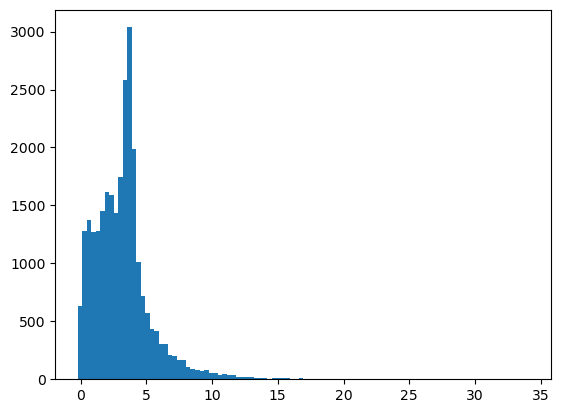

In [76]:
random.seed(100)
np.random.seed(100)

# read in data from nba csv file
df_dqn = pd.read_csv('NBA_PBP_2018-19_processed_points.csv')
# sort by Player, GameId, and Interval
df_dqn = df_dqn.sort_values(by=['Player', 'GameId', 'Interval'], ascending=True)
df_dqn = df_dqn[df_dqn['RollingAvgPlayerPoints'] > 15]
names = df_dqn['Player']
# drop date, player, gameid
df_dqn = df_dqn[['Interval', 'CumulativePlayerPointsInterval', 'Home', 'TeamRest',
        'OpponentTeamRest', 'CumulativeTeamPointsInterval',
        'CumulativeOpponentPointsInterval', 'ScoreMarginInterval',
        'ScoreMarginxTimeRemainingInterval',
        'ScoreMarginxTimeRemaining2Interval', 'RollingAvgPlayerPoints',
        'RollingAverageOpposingTeamAllowedPoints', 'RollingAverageTeamPoints']]
# drop rows with missing values
df_dqn = df_dqn.dropna()
# convert to numpy array
feature_vals = df_dqn.to_numpy()

# Standardize the columns of the data except for those used in exer
means_vec = np.mean(feature_vals, axis=0)
std_vec = np.std(feature_vals, axis=0)
means_vec[0] = 0
std_vec[0] = 1
means_vec[1] = 0
std_vec[1] = 1
means_vec[10] = 0
std_vec[10] = 1
feature_vals = (feature_vals - means_vec) / std_vec
next_features = copy.deepcopy(feature_vals)
# move first row to last row
next_feature_vals = np.roll(next_features, -1, axis=0)

fldq: torch.nn.Module = fitted_dql_put_option(
    feature_vals=feature_vals,
    next_feature_vals=next_feature_vals,
    training_iters=500000,
    num_intervals=4,
)
names = names.to_numpy()

print("Fitted DQL Model")

res_dqn = fldq.forward_in_batches(torch.tensor(feature_vals, dtype=torch.float))
# convert res to numpy array from torch tensor
res_dqn = res_dqn.numpy()
# make a histogram using res
plt.hist(res_dqn, bins=100)

df_dqn['Player'] = names
df_dqn['res'] = res_dqn
df_dqn.to_csv('dqn_nba_output.csv')
print('done')

### 6.) Plot Points Development as Demo

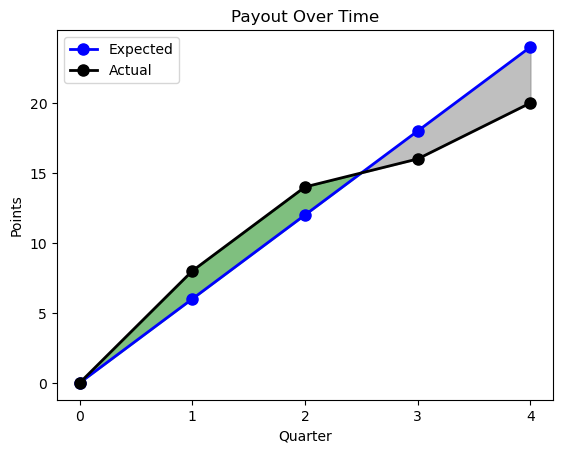

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the expected and actual scores
expected_points = np.array([0, 6, 12, 18, 24])
actual_points = np.array([0, 8, 14, 16, 20])

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points >= expected_points), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set the title and legend
ax.set_title('Payout Over Time')
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks(np.arange(0, max(actual_points) + 5, 5))

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels(np.arange(0, max(actual_points) + 5, 5))

# Display the plot
plt.savefig('example_full.png')
plt.show()



### 7.) Real Example from Data Using LSPI

        Interval  CumulativePlayerPointsInterval  Home  TeamRest  \
107758         0                             0.0     0       2.0   
18678          1                            12.0     0       2.0   
40948          2                            14.0     0       2.0   
63218          3                            31.0     0       2.0   
85488          4                            31.0     0       2.0   

        OpponentTeamRest  CumulativeTeamPointsInterval  \
107758               2.0                             0   
18678                2.0                            51   
40948                2.0                            79   
63218                2.0                           112   
85488                2.0                           142   

        CumulativeOpponentPointsInterval  ScoreMarginInterval  \
107758                                 0                    0   
18678                                 35                   16   
40948                                 60       

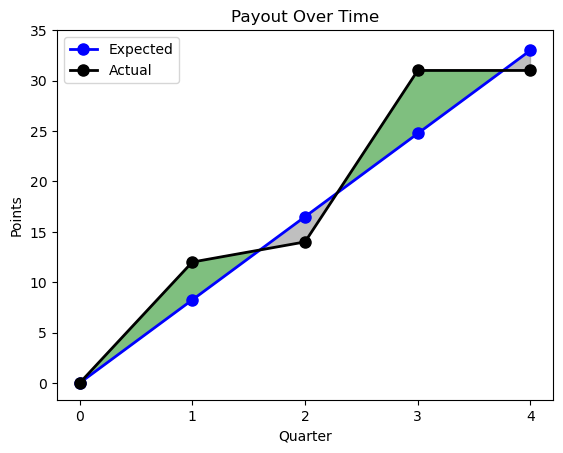

In [102]:
# Get the data for Steph Curry vs the Nuggets
df_curry_lspi = df_lspi[df_lspi['Player'] == 'S. Curry - curryst01'].iloc[5:10]
print(df_curry_lspi.head())
expected_points = np.array([0, 8.25, 16.5, 24.75, 33])
actual_points = np.array([0, 12, 14, 31, 31])

# Payoff plot
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points >= expected_points), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set the title and legend
ax.set_title('Payout Over Time')
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks(np.arange(0, max(actual_points) + 5, 5))

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels(np.arange(0, max(actual_points) + 5, 5))

# Display the plot
plt.savefig('example_full.png')
plt.show()

### Example from last Sunday: Lakers vs Knicks

In [113]:
# STATS for AD leading up to game:
data_ad = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 23.2, 111.7, 115.4]
#STATS for DLO leading up to game:
data_dlo = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 17.8, 111.7, 115.4]
# normalize
data_dlo = (data - means_vec) / std_vec

# opt price at start
price = fldq.forward_in_batches(torch.tensor(data_dlo, dtype=torch.float))
print('Initial Flexpoints price: ' + str(price))

# calculate optimal policy at quarters 1-3:

data_1_ad = [1, 2, 1, 1, 0, 27, 31, -4, -144, -5184, 17.8, 111.7, 115.4]
data_2_ad = [2, 12, 1, 1, 0, 59, 62, -3, -72, -1728, 17.8, 111.7, 115.4]
data_3_ad = [3, 14, 1, 1, 0, 86, 85, 1, 12, 144, 17.8, 111.7, 115.4]

data_1 = [1, 13, 1, 1, 0, 27, 31, -4, -144, -5184, 17.8, 111.7, 115.4]
data_2 = [2, 23, 1, 1, 0, 59, 62, -3, -72, -1728, 17.8, 111.7, 115.4]
data_3 = [3, 31, 1, 1, 0, 86, 85, 1, 12, 144, 17.8, 111.7, 115.4]
# normalize
data_1 = (data_1 - means_vec) / std_vec
data_2 = (data_2 - means_vec) / std_vec
data_3 = (data_3 - means_vec) / std_vec

price_1 = fldq.forward_in_batches(torch.tensor(data_1, dtype=torch.float))
price_2 = fldq.forward_in_batches(torch.tensor(data_2, dtype=torch.float))
price_3 = fldq.forward_in_batches(torch.tensor(data_3, dtype=torch.float))

print('Val of continue at end of quarter 1: ' + str(price_1))
print('Val of continue at end of quarter 2: ' + str(price_2))
print('Val of continue at end of quarter 3: ' + str(price_3))

Initial Flexpoints price: tensor([0.0983])
Val of continue at end of quarter 1: tensor([6.3503])
Val of continue at end of quarter 2: tensor([10.1952])
Val of continue at end of quarter 3: tensor([15.9574])


### 8.) Generate Plot for Example

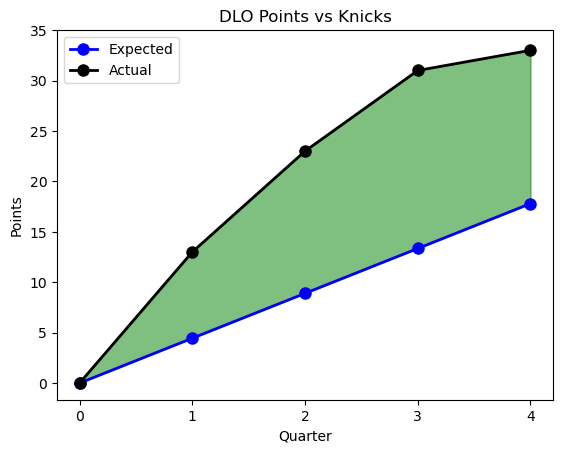

In [116]:
expected_points = np.array([0, 4.45, 8.9, 13.35, 17.8])
actual_points = np.array([0, 13, 23, 31, 33])

# Payoff plot
fig, ax = plt.subplots()

# Plot the expected and actual scores with modified settings
ax.plot(expected_points, color='blue', linewidth=2, marker='o', markersize=8, label='Expected')
ax.plot(actual_points, color='black', linewidth=2, marker='o', markersize=8, label='Actual')

# Fill the area between the lines where actual > expected with green with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points >= expected_points), interpolate=True, color='green', alpha=0.5)

# Fill the area between the lines where actual < expected with red with transparency
ax.fill_between(np.arange(len(expected_points)), expected_points, actual_points,
                where=(actual_points < expected_points), interpolate=True, color='grey', alpha=0.5)

# Set the x-axis and y-axis labels
ax.set_xlabel('Quarter')
ax.set_ylabel('Points')

# Set the title and legend
ax.set_title('DLO Points vs Knicks')
ax.legend()

# Set the tick intervals for x and y axes
ax.set_xticks(np.arange(0, len(expected_points - 1)))
ax.set_yticks(np.arange(0, max(actual_points) + 5, 5))

# Set the tick labels for x and y axes
ax.set_xticklabels(np.arange(0, len(expected_points)))
ax.set_yticklabels(np.arange(0, max(actual_points) + 5, 5))

# Display the plot
plt.savefig('example_full.png')
plt.show()

In [115]:
payoff = actual_points - expected_points
print(payoff)

[ 0.    8.55 14.1  17.65 15.2 ]
